In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from seglearn.transform import InterpLongToWide, SegmentX, FeatureRep
from seglearn.pipe import Pype

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold
%matplotlib inline

## Initial testing

In [ ]:
acc_data = pd.read_csv('./data/acc_29_R_5_2.csv')
gyro_data = pd.read_csv("./data/gyro_10_L_0_1.csv")
mag_data = pd.read_csv("./data/mag_10_L_0_1.csv")

# Transforming time values into proper date/time series data
# acc_data['dt'] = pd.to_datetime(acc_data['time'], unit='s')
acc_data['dt'] = pd.to_timedelta(acc_data['time'], unit='s')
# gyro_data['dt'] = pd.to_datetime(gyro_data['time'], unit='s')
gyro_data['dt'] = pd.to_timedelta(gyro_data['time'], unit='s')
# mag_data['dt'] = pd.to_datetime(mag_data['time'], unit='s')
mag_data['dt'] = pd.to_timedelta(mag_data['time'], unit='s')

acc_data = acc_data.set_index('dt')
gyro_data = gyro_data.set_index('dt')
mag_data = mag_data.set_index('dt')
acc_data.tail()

### Transformations
1. resample to 0.01s (nearest or mean)
2. interpolate any resulting NaNs
3. create new time column

**NOTE**: resampling with 'nearest' will not change the data series x, y, z, but map them to the nearest value in the new t value (timeseries at the desired frequency). Resampling with 'mean' will interpolate between datapoints for each new interval. Both produce acceptable results

In [ ]:
sampled_acc_data = acc_data.resample('0.01S').nearest()
sampled_acc_data = sampled_acc_data.interpolate()
sampled_acc_data.reset_index(inplace=True)
# sampled_acc_data['t'] = sampled_acc_data['dt'].dt.strftime('%S.%f')
sampled_acc_data['t'] = sampled_acc_data['dt'].dt.total_seconds() 
sampled_acc_data['t'] = pd.to_numeric(sampled_acc_data['t'])
sampled_acc_data = sampled_acc_data[['time', 't', 'x', 'y', 'z']]

In [ ]:
sampled_acc_data.tail()

In [ ]:
sampled_gyro_data = gyro_data.resample('0.01S').nearest()
sampled_gyro_data = sampled_gyro_data.interpolate()
sampled_gyro_data.reset_index(inplace=True)
# sampled_gyro_data['t'] = sampled_gyro_data['dt'].dt.strftime('%S.%f')
sampled_gyro_data['t'] = sampled_gyro_data['dt'].dt.total_seconds()
sampled_gyro_data['t'] = pd.to_numeric(sampled_gyro_data['t'])
sampled_gyro_data = sampled_gyro_data[['time', 't', 'x', 'y', 'z']]
sampled_gyro_data.tail()

In [ ]:
sampled_mag_data = mag_data.resample('0.01S').nearest()
sampled_mag_data = sampled_mag_data.interpolate()
sampled_mag_data.reset_index(inplace=True)
# sampled_mag_data['t'] = sampled_mag_data['dt'].dt.strftime('%S.%f')
sampled_mag_data['t'] = sampled_mag_data['dt'].dt.total_seconds()
sampled_mag_data['t'] = pd.to_numeric(sampled_mag_data['t'])
sampled_mag_data = sampled_mag_data[['time', 't', 'x', 'y', 'z']]
sampled_mag_data.tail()

In [ ]:
plt.plot(sampled_acc_data['t'][-100:], sampled_acc_data['z'][-100:], 'co-')
plt.plot(acc_data['time'][-100:], acc_data['z'][-100:])
print(sampled_acc_data['t'][0])
print(sampled_acc_data['t'].iloc[-1])

In [ ]:
plt.plot(sampled_gyro_data['t'][-100:], sampled_gyro_data['x'][-100:], 'co-')
plt.plot(gyro_data['time'][-100:], gyro_data['x'][-100:])
print(sampled_gyro_data['t'][0])
print(sampled_gyro_data['t'].iloc[-1])

In [ ]:
plt.plot(sampled_mag_data['t'][-100:], sampled_mag_data['x'][-100:], 'co-')
plt.plot(mag_data['time'][-100:], mag_data['x'][-100:])
print(sampled_mag_data['t'][0])
print(sampled_mag_data['t'].iloc[-1])

In [ ]:
def resample_timeseries(filename, delta='0.01S'):
    """
    Returns a resampled timeseries dataframe
    """
    df = pd.read_csv(filename)
    df.drop_duplicates('time', inplace=True)
    # df['dt'] = pd.to_datetime(df['time'], unit='s')
    df['dt'] = pd.to_timedelta(df['time'], unit='s')
    df.set_index('dt', inplace=True)

    try:
        sampled_df = df.resample(delta, base=0).nearest()
#         sampled_df = sampled_df.asfreq('0.01S')
#         sampled_df = df.asfreq(delta)
    except ValueError as err:
        print("Nearest interpolation failed; using mean instead")
        sampled_df = df.resample(delta).mean()

    sampled_df.interpolate(inplace=True)
    sampled_df.reset_index(inplace=True)
    # sampled_df['t'] = sampled_df['dt'].dt.strftime('%S.%f')
    sampled_df['t'] = sampled_df['dt'].dt.total_seconds() 
    sampled_df['t'] = pd.to_numeric(sampled_df['t'])
    sampled_df = sampled_df[['time', 't', 'x', 'y', 'z']]
    return sampled_df


In [ ]:
test = resample_timeseries("./data/gyro_30_R_5_2.csv")
round(min(test['t']), 2)

In [ ]:
test.groupby(test['t'].floor('Min')).last().resample('Min').asfreq()

## Parse original data into resampled timeseries data

In [ ]:
# root_dir = './data/'
# data_files = glob.glob('./data/*.csv')
# start = 0
# end = 1e6
# for f in data_files:
#     # print(f)
#     resampled = resample_timeseries(f)
#     lb = max(resampled['t'])
#     if lb > start:
#         start = lb
# #     ub = max(resampled['t'])
#     if lb < end:
#         end = ub
#     # filename = f.split("/")[-1]
#     # resampled.to_csv("./resampled/" + filename, sep=',', index=False)
# print(start, end)

## Training set preparation
We decided to focus on one sensor at the time, starting with gyro x, y, z. We create a resampled nda .npy for each sensor. We ensure that each sequence has the same number of datapoints (doesn't necessarily have to start and end at the same time). 88.88% have more than 3000 datapoints (seems like a good cutoff)

In [12]:
data_files = glob.glob('./resampled/acc*.csv')
N = len(data_files)

In [ ]:
## cropped_resampled_acc_nar.npy
l = []
seqlen = 200
X = []
files = []
# subjects = np.zeros(N)
# exnum = np.zeros(N)
# quality = np.zeros(N)
subjects = []
exnums = []
quality = []
for i, f in enumerate(data_files):
    x = pd.read_csv(f)
    # Parse subject, exercise and quality from filename
    fsplit = f.split("_")
#     subjects[i] = int(fsplit[1])
#     exnum[i] = int(fsplit[3])
#     quality[i] = int(fsplit[-1].split(".")[0])
    s = int(fsplit[1])
    ex = int(fsplit[3])
    q = int(fsplit[-1].split(".")[0])
    seqs = x.shape[0] // seqlen
    for j in range(seqs+1):
        if j == seqs: # seq_length < seqlen
            x_seq = x.iloc[j*seqlen:, 1:].to_numpy()
        else:
            x_seq = x.iloc[j*seqlen:(j+1)*seqlen, 1:].to_numpy()
        X.append(x_seq)
        subjects.append(s)
        exnums.append(ex)
        quality.append(q)
    break
#     x = x.iloc[:, 1:].to_numpy()
#     X.append(x)
#     files.append(f)

In [13]:
l = []
seqlen = 200
X = []
files = []
# subjects = np.zeros(N)
# exnum = np.zeros(N)
# quality = np.zeros(N)
subjects = []
exnums = []
quality = []
for i, f in enumerate(data_files):
    # Parse subject, exercise and quality from filename
    fsplit = f.split("_")
    s = int(fsplit[1])
    ex = int(fsplit[3])
    q = int(fsplit[-1].split(".")[0])
    
    xa = pd.read_csv(f)
    gf = f.replace("acc", "gyro")
#     print(f, gf)
    xg = pd.read_csv(gf)
    min_t = np.max((min(xa['t']), min(xg['t'])))
    min_t = round(min_t, 2)
    max_t = np.min((max(xa['t']), max(xg['t'])))
    max_t = round(max_t, 2)
#     print(min_t, max_t)
    
    # Crop
    xa = xa[(xa['t'].round(2) >= min_t) & (xa['t'].round(2) <= max_t)]
    xg = xg[(xg['t'].round(2) >= min_t) & (xg['t'].round(2) <= max_t)]
    assert(len(xa) == len(xg))
    
    # Rename columns
    xa = xa.rename(columns={'x': 'ax', 'y': 'ay', 'z': 'az'})
    xg = xg.rename(columns={'x': 'gx', 'y': 'gy', 'z': 'gz'})
 
    seqs = xa.shape[0] // seqlen 
    
    for j in range(seqs + 1):
        if j == seqs: # seq_length < seqlen
            a_seq = xa.iloc[j*seqlen:, 1:].to_numpy()
            g_seq = xg.iloc[j*seqlen:, 1:].to_numpy()
        else:
            a_seq = xa.iloc[j*seqlen:(j+1)*seqlen, 1:].to_numpy()
            g_seq = xg.iloc[j*seqlen:(j+1)*seqlen, 1:].to_numpy()
            
        x_seq = np.concatenate((a_seq, g_seq[:, 1:]), axis=1)        
        X.append(x_seq)
        subjects.append(s)
        exnums.append(ex)
        quality.append(q)
#     x = x.iloc[:, 1:].to_numpy()
#     X.append(x)
#     files.append(f)

In [20]:
# subjects = np.array(subjects)
# exnum = np.array(exnums)
# quality = np.array(quality) 

In [21]:
# data = {"X": X, "filenames": files, "subject": subjects, "exnum": exnum, "quality": quality}
# data = {"X": X, "subject": subjects, "exnum": exnum, "quality": quality}

In [22]:
# np.save("cropped_resampled_acc_gyro_nar.npy", data)

## Data visualization

Helper function to compare two timeseries qualitatively.
As a pace holder we're showing the differenes between the original and resampled timeseries data (the resampled data is the one actually used in this project)

In [ ]:
acc = pd.read_csv('./resampled/acc_10_L_0_1.csv')
gyro = pd.read_csv('./resampled/gyro_10_L_0_1.csv')

In [ ]:
newindex = np.arange(min(gyro['t']), max(gyro['t']), 0.01)
df_reindexed = gyro.reindex(index = newindex)
df_reindexed.head()

In [ ]:
df_reindexed.interpolate(method = 'linear', inplace = True)
df_reindexed.head()

In [128]:
def plot_comparison(x, ylabel, index=None, reconx=None, labels = None, ax = None, title=""):
    """
    Plots original data against reconstructed or synthesized data
        x: numpy array of size (N, 4)
        reconx: numpy array of size (N, 4)
    """
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()

    if index is None: # defaults to all the data
        index = -1
    
    ax.plot(x[:,0][:index], x[:,1][:index], 'r-', label="x")
    ax.plot(x[:,0][:index], x[:,2][:index], 'g-', label="y")
    ax.plot(x[:,0][:index], x[:,3][:index], 'b-', label="z")
    if reconx is not None:
        ax.plot(reconx[:, 0][:index], reconx[:, 1][:index], 'c-', linestyle=':', label="rec_x")
        ax.plot(reconx[:, 0][:index], reconx[:, 2][:index], 'm-', linestyle=':', label="rec_y")
        ax.plot(reconx[:, 0][:index], reconx[:, 3][:index], 'y-', linestyle=':', label="rec_z")
#     ax.set_xlabel('time [s]')
#     ax.set_ylabel(r'acceleration $[ms^{-2}]$')
    ax.set_title(title)
    ax.legend(loc="upper right")

In [154]:
def plot_grid(rows, cols, label, index=None, data=None, axis=None, titles=None):
    """
    Plot rows x cols subplot grid
        data: list of numpy arrays
        axis: sensor data axis to display (0: x, 1: y, 2: z) (default: all)
        index: upper bound for data to display
    """
    N = rows*cols
    if data is None or len(data) != N:
        print("Number of filenames does not match grid size")
        return None
    
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(24, 12))
    ax = [plt.subplot(rows,cols,i+1) for i in range(N)]

    for i, a in enumerate(ax):
        X = data[i]
        plot_comparison(X, ylabel=label, index=index, ax=a, title=titles[i])
    
    fig.text(0.5, 0.04, 'time [s]', ha='center', fontsize=26)
    fig.text(0.02, 0.5, r'acceleration $[ms^{-2}]$', va='center', rotation='vertical', fontsize=26)
    fig.tight_layout(pad=3.0)





**NOTE**: showing x, y and z on the same plot might be too cluttered

## Input visualization
It may be worthwhile to show timeseries data for the different exercises classes to show what the VAE is embedding in latent space
['PEN','FLEX', 'SCAP', 'ABD', 'IR', 'ER', 'DIAG', 'ROW', 'SLR']

In [135]:
# Accelerometer good exercises
data_files = glob.glob('./resampled/acc*1.csv')

In [136]:
num_ex = 9
exercise_data = []
for i in range(num_ex):
    exercise_data.append(list(filter(lambda x: str(i) == x.split("_")[-2], data_files)))

In [137]:
ttl = ['Pendulum (PEN)','Flexion (FLEX)', 'Scapular raise (SCAP)', 'Abduction (ABD)', 'Internal rotation (IR)', 'External rotation (ER)', 'Diagonal raise (DIAG)', 'Upright row (ROW)', 'Shoulder lateral raise (SLR)']

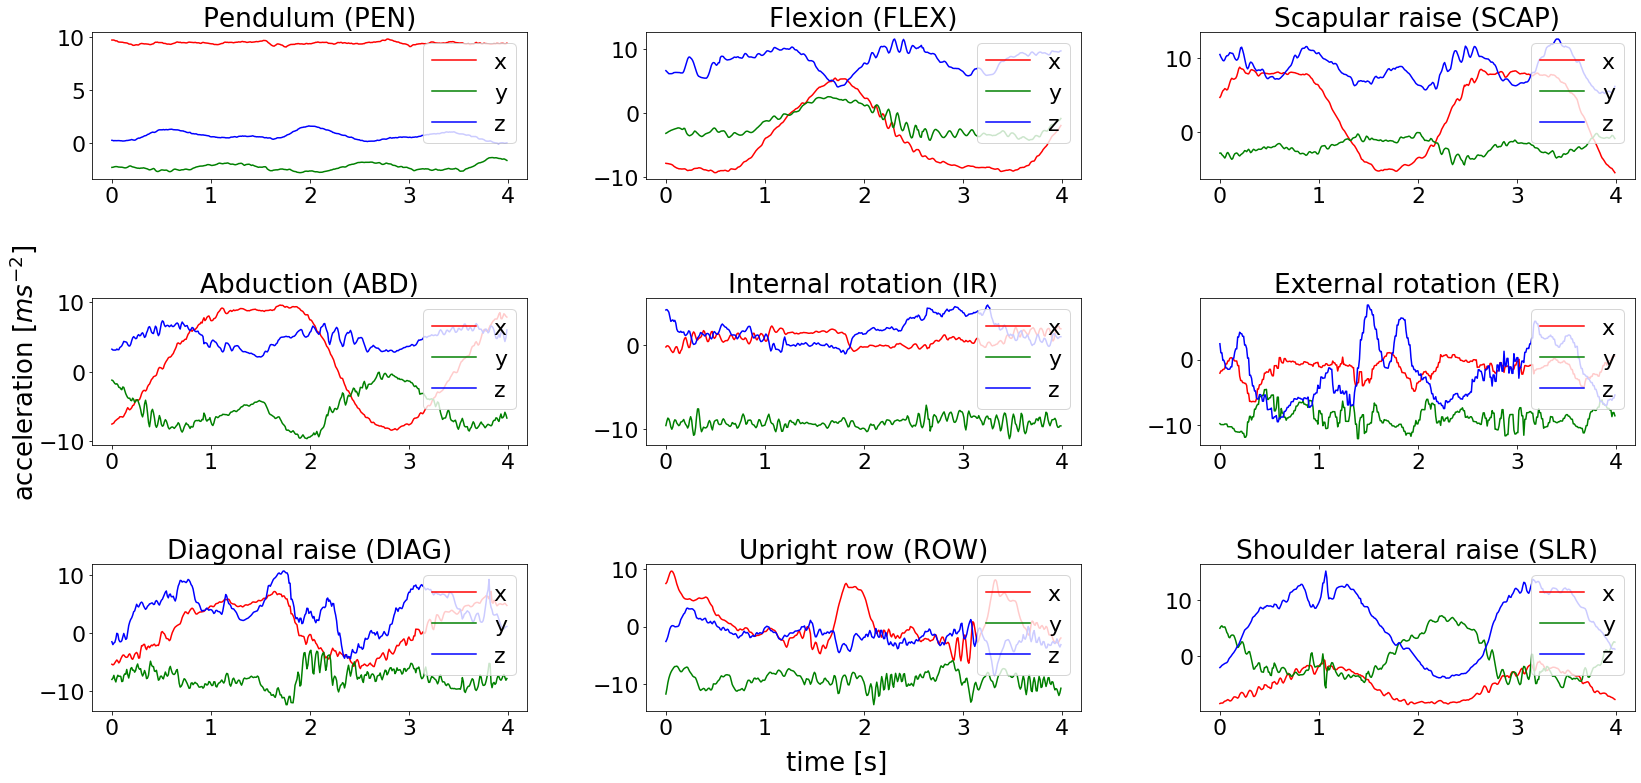

In [175]:
# PEN
sample_files = []
for i in range(num_ex):
    sample = np.random.randint(len(exercise_data[i]), size=1)
    sample_files.append(exercise_data[i][sample[0]])

sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(3, 3, 'acceleration [ms^-2]', data=sample_data, index=400, titles=ttl)

TypeError: 'NoneType' object is not subscriptable

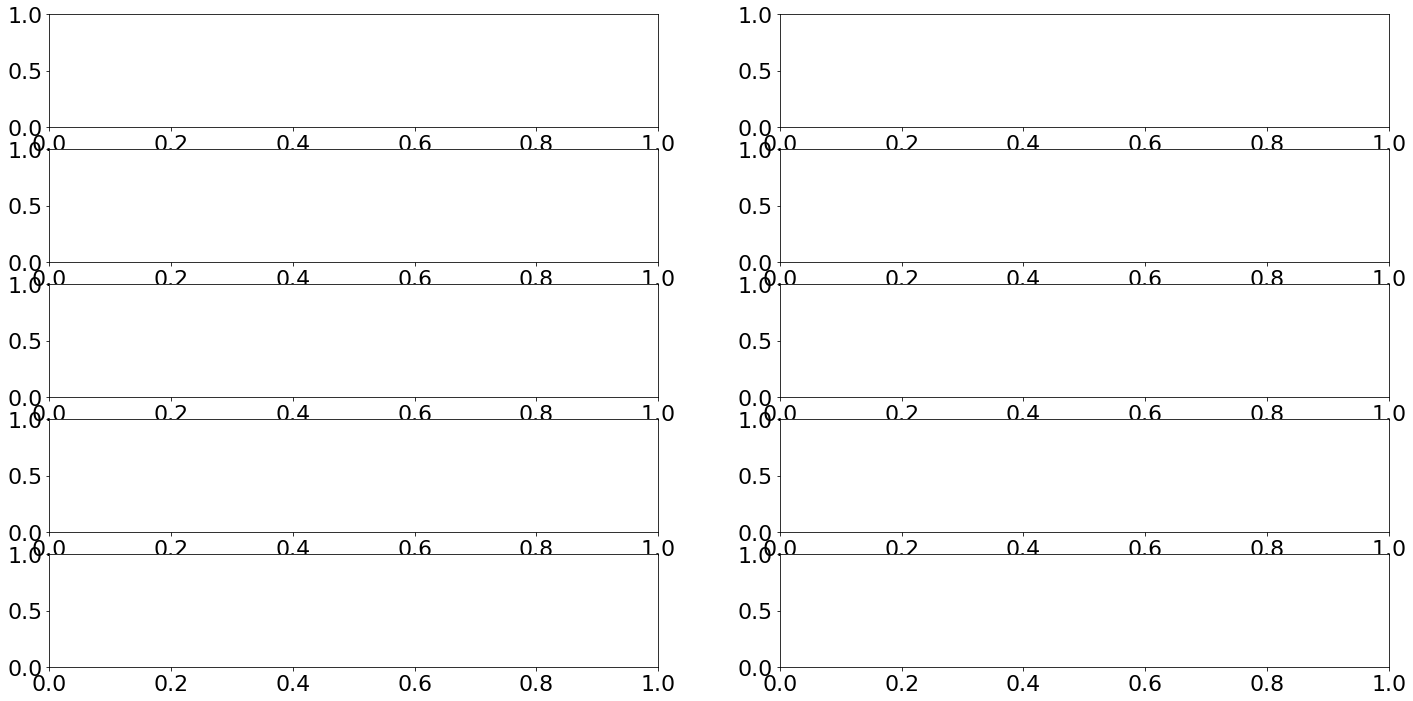

In [139]:
# FLEX
samples = np.random.randint(len(exercise_data[1]), size=10)
sample_files = [exercise_data[1][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# SCAP
samples = np.random.randint(len(exercise_data[2]), size=10)
sample_files = [exercise_data[2][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# ABD
samples = np.random.randint(len(exercise_data[3]), size=10)
sample_files = [exercise_data[3][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# IR
samples = np.random.randint(len(exercise_data[4]), size=10)
sample_files = [exercise_data[4][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# ER
samples = np.random.randint(len(exercise_data[5]), size=10)
sample_files = [exercise_data[5][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# DIAG
samples = np.random.randint(len(exercise_data[6]), size=10)
sample_files = [exercise_data[6][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# ROW
samples = np.random.randint(len(exercise_data[7]), size=10)
sample_files = [exercise_data[7][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

In [ ]:
# SLR
samples = np.random.randint(len(exercise_data[8]), size=10)
sample_files = [exercise_data[8][i] for i in samples]
sample_data = [pd.read_csv(f).iloc[:, 1:].to_numpy() for f in sample_files]
plot_grid(5, 2, 'acc', data=sample_data, index=1000)

## Report figures

In [ ]:
data_files = glob.glob('./resampled/*.csv')


In [ ]:
## cropped_resampled_acc_nar.npy
seqlen = 200
N
X = []
subjects = np.zeros(N)
exnum = np.zeros(N)
quality = np.zeros(N)
for i, x in enumerate(reconstructed_x):
    # Fill in subject, exercise and quality
    subjects[i] = 
    exnum[i] = 
    quality[i] = 
    
    X.append(x)

# Export
data = {"X": X, "subject": subjects, "exnum": exnum, "quality": quality}
np.save("recon_acc_nar.npy", data)
